<a href="https://colab.research.google.com/github/Arshad221b/Basic-ML/blob/main/Monkey_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"arshadsk","key":"ddc6944539168e5b7afa87180c98a51e"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download -d slothkong/10-monkey-species

10-monkey-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
! unzip 10-monkey-species.zip -d monkey_species

Archive:  10-monkey-species.zip
replace monkey_species/monkey_labels.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: monkey_species/monkey_labels.txt  
  inflating: monkey_species/training/training/n0/n0018.jpg  
  inflating: monkey_species/training/training/n0/n0019.jpg  
  inflating: monkey_species/training/training/n0/n0020.jpg  
  inflating: monkey_species/training/training/n0/n0021.jpg  
  inflating: monkey_species/training/training/n0/n0022.jpg  
  inflating: monkey_species/training/training/n0/n0023.jpg  
  inflating: monkey_species/training/training/n0/n0024.jpg  
  inflating: monkey_species/training/training/n0/n0025.jpg  
  inflating: monkey_species/training/training/n0/n0026.jpg  
  inflating: monkey_species/training/training/n0/n0027.jpg  
  inflating: monkey_species/training/training/n0/n0028.jpg  
  inflating: monkey_species/training/training/n0/n0029.jpg  
  inflating: monkey_species/training/training/n0/n0030.jpg  
  inflating: monkey_species/training/training

In [5]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt
import cv2
import random 
import os

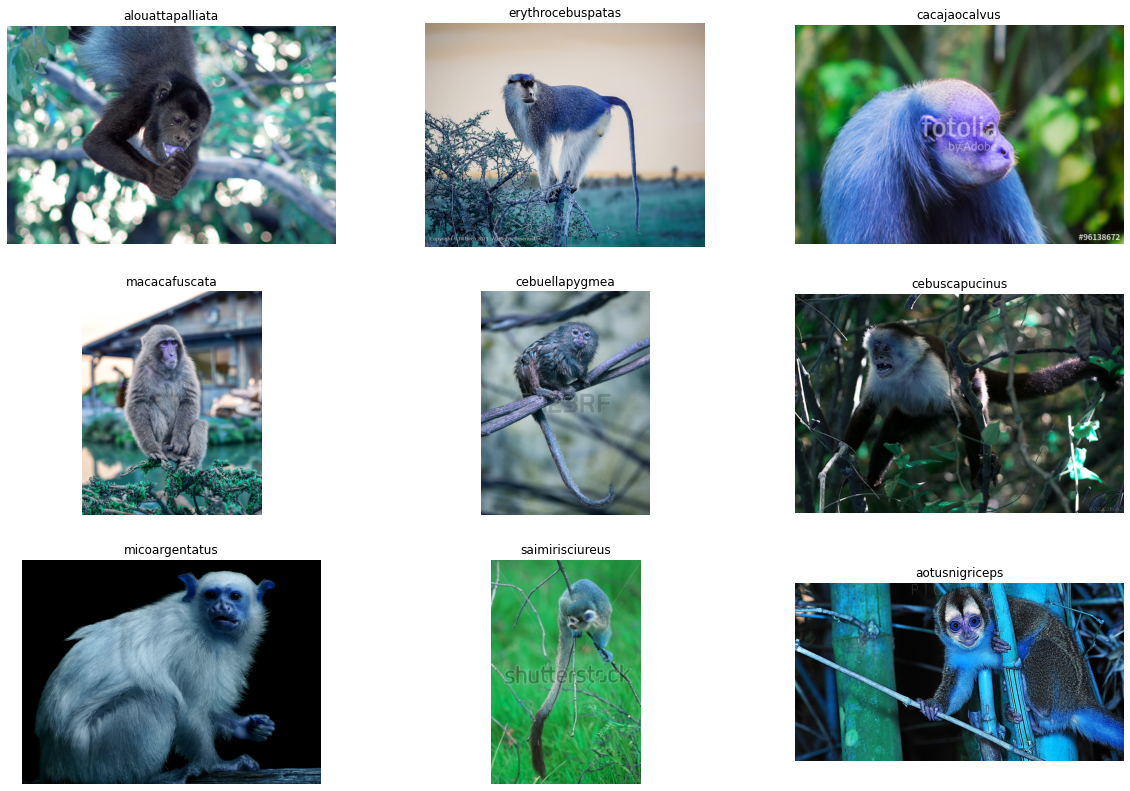

In [6]:
path = 'monkey_species/training/training/n'
fig = plt.figure(figsize=(20, 14))
rows = 3
columns = 3

names = ['alouattapalliata', 'erythrocebuspatas', 'cacajaocalvus', 'macacafuscata', 'cebuellapygmea', 
         'cebuscapucinus', 'micoargentatus', 'saimirisciureus', 'aotusnigriceps', 'trachypithecusjohnii']
for i in range(1, 10):
  k = random.randint(20,100)
  l = os.listdir(path + str(i-1))[k]
  Images = cv2.imread(path + str(i-1)+ '/' + str(l))
  fig.add_subplot(rows, columns, i)
  plt.imshow(Images)
  plt.axis('off')
  plt.title(names[i-1])

In [7]:
train_dir = '/content/monkey_species/training/training/'
validation_dir = '/content/monkey_species/validation/validation/'

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2
                                   )
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (400, 300),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size = (400, 300),
    batch_size = 8,
    class_mode = 'categorical'
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [9]:
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (400, 300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-05-30 04:09:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  80.9MB/s    in 1.0s    

2021-05-30 04:10:00 (80.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 300, 3) 0                 

In [10]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (10, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = 'SGD', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [14]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 16,
            epochs = 20,
            validation_steps = 8,
            verbose = 1)

Epoch 1/20
16/16 [==============================] - 24s 2s/step - loss: 0.2588 - accuracy: 0.9408 - val_loss: 0.4846 - val_accuracy: 0.8750
Epoch 2/20
16/16 [==============================] - 24s 2s/step - loss: 0.2056 - accuracy: 0.9592 - val_loss: 0.2568 - val_accuracy: 0.9062
Epoch 3/20
16/16 [==============================] - 26s 2s/step - loss: 0.2253 - accuracy: 0.9375 - val_loss: 0.2622 - val_accuracy: 0.9062
Epoch 4/20
16/16 [==============================] - 24s 1s/step - loss: 0.2393 - accuracy: 0.9245 - val_loss: 0.2408 - val_accuracy: 0.9531
Epoch 5/20
16/16 [==============================] - 26s 2s/step - loss: 0.1763 - accuracy: 0.9668 - val_loss: 0.3490 - val_accuracy: 0.8594
Epoch 6/20
16/16 [==============================] - 25s 2s/step - loss: 0.2168 - accuracy: 0.9286 - val_loss: 0.1777 - val_accuracy: 0.9531
Epoch 7/20
16/16 [==============================] - 25s 2s/step - loss: 0.1915 - accuracy: 0.9612 - val_loss: 0.1838 - val_accuracy: 0.9375
Epoch 8/20
16/16 [==

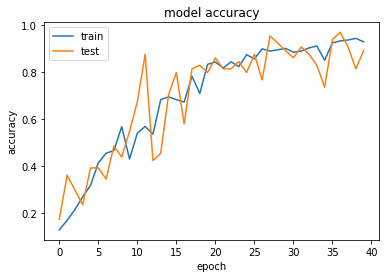

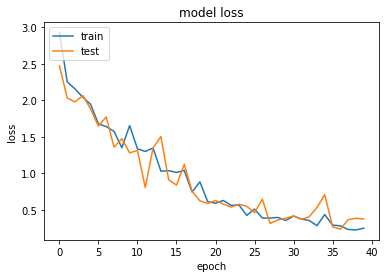

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save('my_checkpoint.h5')